In [1]:
!pip install torch.geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 575.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


###TSNE Visualizations

In [30]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 55.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


###We take a graph as input
- We will take the cora citation network as input and will try to see the various features in the dataset

In [25]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch

dataset=Planetoid(root='data/Planetoid',name='Cora',transform=NormalizeFeatures())


#Lets explore the graph
dataset=dataset[0]
num_classes=torch.unique(dataset.y).shape[0]

print("Number of Graphs ", len(dataset))
print("Number of features ", dataset.num_features)
print("Number of classes ", num_classes)

#=====================================================

print("number of nodes \t", dataset.num_nodes)
print("number of edges \t", dataset.num_edges)
print("training mask \t", dataset.train_mask.sum())
print("validation mask \t", dataset.val_mask.sum())
print("test mask \t", dataset.test_mask.sum())

print("Does the graph contains isolated nodes \t", dataset.has_isolated_nodes())
print("Does the graph contains self loops \t", dataset.has_self_loops())
print("is the graph undirected \t", dataset.is_undirected())

# feature matrix X
print("features of the graph \t", dataset.x.shape)

# class labels
print("labels of the nodes \t", dataset.y.shape)

# structural information
print("List of edges in the graph \t", dataset.edge_index.shape)

Number of Graphs  6
Number of features  1433
Number of classes  7
number of nodes 	 2708
number of edges 	 10556
training mask 	 tensor(140)
validation mask 	 tensor(500)
test mask 	 tensor(1000)
Does the graph contains isolated nodes 	 False
Does the graph contains self loops 	 False
is the graph undirected 	 True
features of the graph 	 torch.Size([2708, 1433])
labels of the nodes 	 torch.Size([2708])
List of edges in the graph 	 torch.Size([2, 10556])


###Define The GCN Network

In [16]:
import torch
import torch.nn as nn
from torch.nn import Linear,Softmax,CrossEntropyLoss
from torch.optim import Adam
import matplotlib.pyplot as plt

In [26]:
class GCN_Model(nn.Module):
  def __init__(self,A,X,hidden_channels):
    super().__init__()
    self.A=A
    self.X=X
    self.softmax=Softmax(dim=1)
    self.reLU=nn.ReLU()
    self.Linear1=Linear(dataset.num_features,hidden_channels)
    self.Linear2=Linear(hidden_channels,num_classes)


  def forward(self):
    x1=self.Linear1(torch.matmul(self.A,self.X))
    x1=self.reLU(x1)
    x2=self.Linear2(torch.matmul(self.A,x1))
    return self.softmax(x2)

###Define The Adjacency Matrix

In [19]:
### The Symmetric Normalized Adjacency Matrix
A=torch.zeros(size=(dataset.num_nodes,dataset.num_nodes))
for i in range(dataset.edge_index.shape[1]):
  A[dataset.edge_index[0][i],dataset.edge_index[1][i]]=1

A1=A+torch.eye(n=dataset.num_nodes)
D=torch.diag(torch.sum(A1,dim=1)) #D+I


D1=torch.sqrt(torch.linalg.inv(D)) #(D+I)^(-1/2)
W1=torch.matmul(D1,A1) #(D+I)^(-1/2)(A+I)
A=torch.matmul(W1,D1) #(D+I)^(-1/2)(A+I)*(D+I)^(-1/2)


###Define The Training Loop Over Multiple Layers

In [20]:
Criterion=CrossEntropyLoss()  #Using Cross Entropy Loss as the loss function
def train(model,optimizer):
  model.train() #Set the model in training mode
  optimizer.zero_grad() #Clear the gradients and set it to zero
  y_pred=model.forward() #Forward Pass
  loss=Criterion(y_pred[dataset.train_mask],dataset.y[dataset.train_mask]) #Calculate the loss in training mode
  loss.backward() #Compute the gradients
  optimizer.step() #Update the parameters
  return loss.item() #Return the loss

In [21]:
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

def test(model):
  model.eval()  #Setting the model to evaluation mode
  y_out=model.forward() #Forward Pass
  y_pred=torch.argmax(y_out,dim=1) #Get the highest predicted class label

  #Convert the predicted and the true label to numpy for score calculation
  y_true=dataset.y[dataset.test_mask].cpu().numpy()
  y_pred=y_pred[dataset.test_mask].cpu().numpy()

  #Calculate the scores
  print(f"Accuracy Score:{accuracy_score(y_pred,y_true)}")
  print(f"Precision Score:{precision_score(y_pred,y_true,average='weighted')}")
  print(f"Recall Score:{recall_score(y_pred,y_true,average='weighted')}")
  print(f"F1 Score:{f1_score(y_pred,y_true,average='weighted')}")

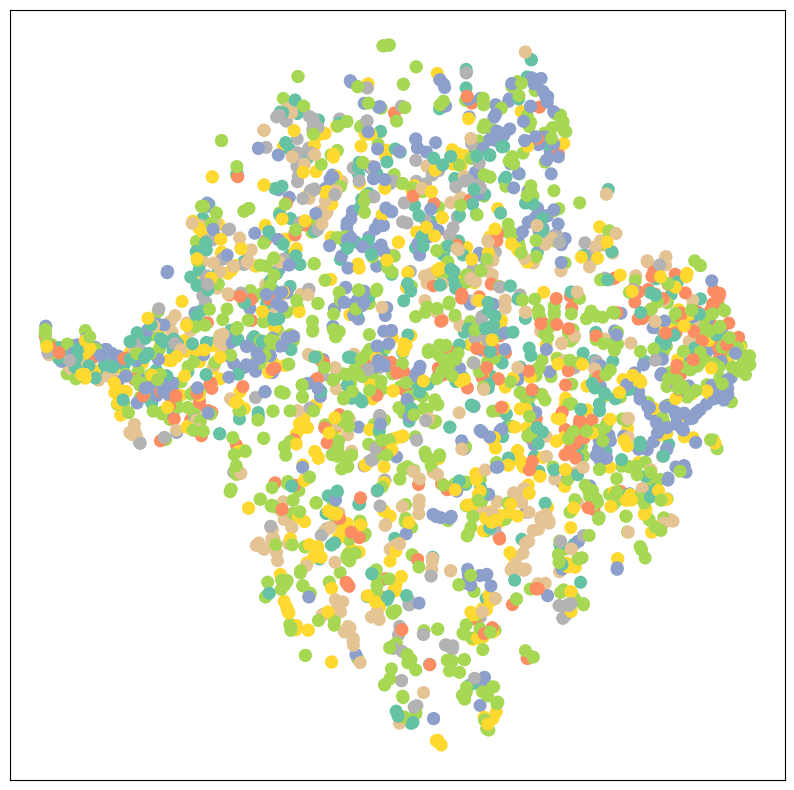

In [33]:
# Embedding visualization before training of Cora dataset
model = GCN_Model(A,dataset.x,hidden_channels=256)

# output from the untrained gcn
out = model.forward()
visualize(out, color=dataset.y)

###Using 256 Hidden Units

In [42]:
model=GCN_Model(A,dataset.x,hidden_channels=256)
optimizer=Adam(model.parameters(),lr=0.01)
epoches=200
training_loss=[]
for _ in range(epoches):
  training_loss.append(train(model,optimizer))

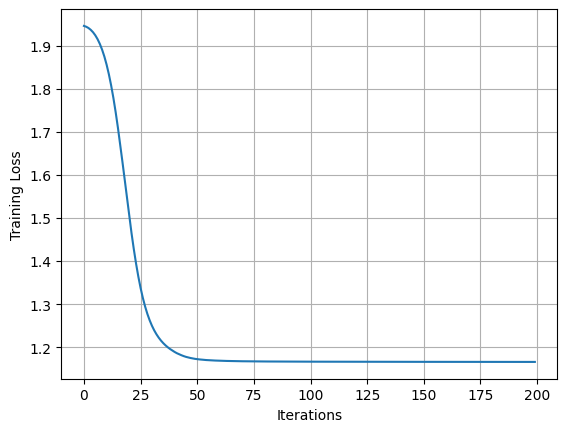

In [43]:
import matplotlib.pyplot as plt
plt.plot(training_loss)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.grid()
plt.show()

In [44]:
test(model)

Accuracy Score:0.786
Precision Score:0.7966808213557501
Recall Score:0.786
F1 Score:0.7841457838038056


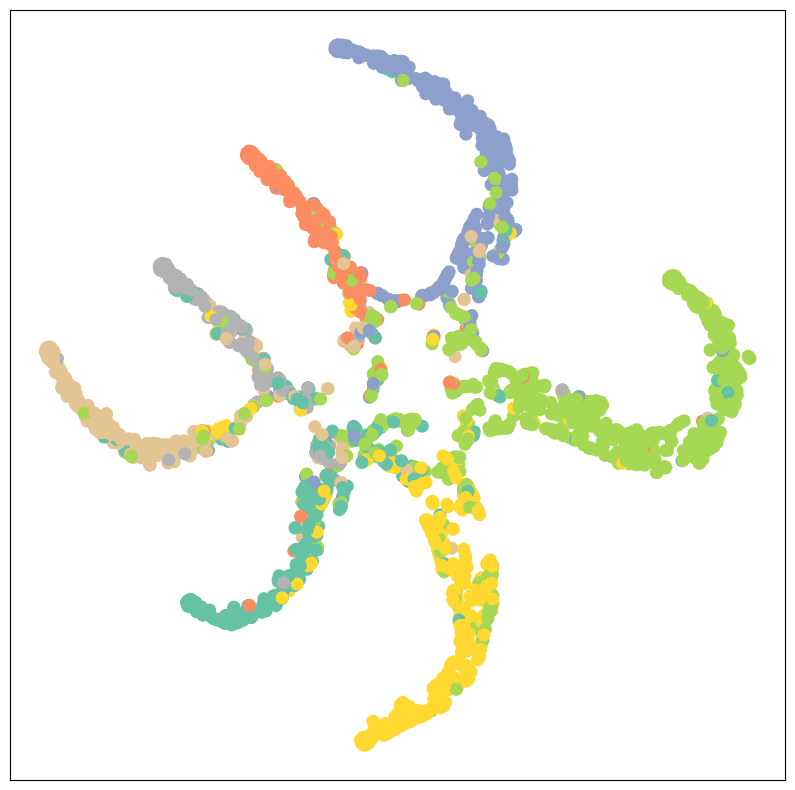

In [45]:
# visualizing node embeddings after training
model.eval()
out = model.forward()
visualize(out, color=dataset.y)